In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


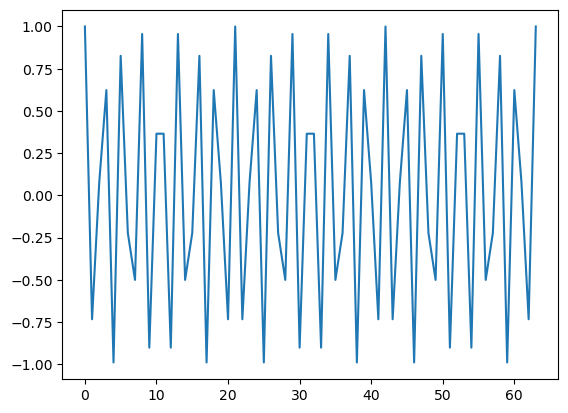

In [12]:
N = 64
t = np.arange(0,2*np.pi,2*np.pi/(N-1))
t = np.linspace(0,2*np.pi,N)
f = 24
s = np.cos(f*t)+1j*np.sin(f*t)
plt.plot(np.real(s))

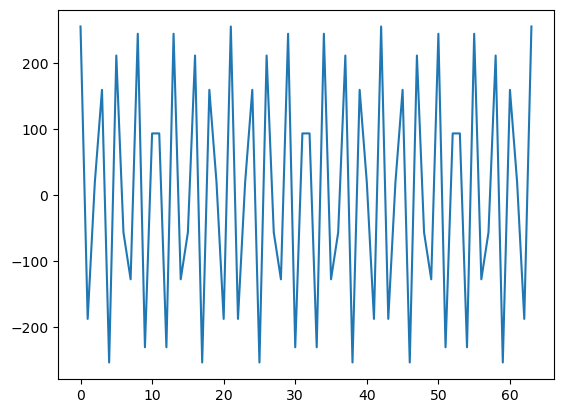

In [69]:
## floating to fixed point conversion
def floating_to_fixed(val,backoff):
    if val < 0:
        out = np.int16(val * 2**15)
    else:
        out = np.int16(val * (2**15 - 1))
    out = out >> backoff
    return out

def floating_to_fixed_new(val,backoff):
    if val < 0:
        step_sz = 1/(2**14)
        out = np.int16(np.round(val/step_sz))
    else:
        step_sz = 1/(2**14)
        out = np.int16(np.round(val/step_sz))
    out = out >> backoff
    return out

def floating_to_fixed_comp(x:complex,backoff:int):
    re = floating_to_fixed_new(np.real(x),backoff)
    im = floating_to_fixed_new(np.imag(x),backoff)
    out = re + 1j * im
    return out

def floating_to_fixed_arr(x:np.ndarray,backoff):
    for i in range(x.size):
        x[i] = floating_to_fixed_comp(x[i],backoff)
    return x

s_fixed = np.zeros(N,dtype=np.complex64)
backoff = 7
for i in range(s.size):
    tmpOutr = floating_to_fixed(np.real(s[i]),backoff)
    tmpOuti = floating_to_fixed(np.imag(s[i]),backoff)
    s_fixed[i] = tmpOutr + 1j * tmpOuti

plt.plot(np.real(s_fixed))

In [70]:
def get_reversed_idx(index):
    N = index.size
    exp = np.emath.logn(4,N)
    num_bits = np.emath.logn(2,N)
    num_shifts = (int(exp) + 1) // 2
    max_shift = (int(exp)-1)*2
    reversed_index = np.zeros(N,dtype=int)
    for i in index:
        tmp = int(0)
        shift = max_shift
        for j in range(num_shifts):
            tmp = tmp | (((3<<(j*2))&i)<<shift) | (((3<<(max_shift-j*2))&i)>>shift)
            shift = shift - 4
        reversed_index[i] = tmp
    return reversed_index

index = np.arange(0,16,dtype=int)
reversed_index = get_reversed_idx(index)
print(reversed_index)

[ 0  4  8 12  1  5  9 13  2  6 10 14  3  7 11 15]


In [71]:
## radix 4 DIT
def radix_4_core(x:np.ndarray[np.complex64], tw:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    out = np.zeros(x.size, dtype=np.complex64)
    for i in range(4):
        out[i] = np.dot(x, tw[:,i])
    return out


def get_complex_exp(k:float) -> complex:
    w = 2*np.pi*k
    out = np.cos(w) - 1j*np.sin(w)
    return out


def get_twiddle_matrix(stage, idx:np.ndarray[int]) -> np.ndarray[np.complex64]:
    out = np.zeros([4, 4], dtype=np.complex64)
    #assert idx.size == (4**stage), f"No of input points in stage: {stage} should be: {4**stage}"
    for i in range(4):
        for j in range(4):
            out[i][j] = get_complex_exp(idx[i]*j/(4**stage))
    return out

def print_matrix(a):
    for row in a:
        print(",".join(map(str, row)))

def print_twiddles(N:int,isFloat:bool,radix:int):
    wa = np.exp(-1j * 2 * np.pi * 0 * np.arange(N/radix) / N)
    for r in range(1,radix):
        wa = np.append(wa, np.exp(-1j * 2 * np.pi * r * np.arange(N/radix) / N))
    if isFloat:
        wp = np.zeros(2*wa.size,dtype=float)
    else:
        wa = floating_to_fixed_arr(wa,0)
        wp = np.zeros(2*wa.size,dtype=int)
    wp[0::2] = np.real(wa)
    wp[1::2] = np.imag(wa)
    numCol = 8
    numRows = int(wp.size/numCol)
    print(wp.size)
    wp = np.reshape(wp, (numRows,numCol))
    print(wp.shape)
    print("w",wp)
    #print("w",wp[0,:])
    #print("w",wp[int(numRows/4),:])
    #print("w",wp[int(numRows/4)*2,:])
    #print("w",wp[int(numRows/4)*3,:])
    #print_matrix(wp)
    
    if isFloat:
        wap = np.zeros(2*wa.size,dtype=float)
    else:
        wap = np.zeros(2*wa.size,dtype=int)
    wap[0::2] = np.real(wa)
    wap[1::2] = np.imag(-wa)
    wap = np.reshape(wap, (numRows,numCol))
    print("wa",wap)
    #print_matrix(wap)
    if isFloat:
        wbp = np.zeros(2*wa.size,dtype=float)
    else:
        wbp = np.zeros(2*wa.size,dtype=int)
    wbp[0::2] = np.imag(wa)
    wbp[1::2] = np.real(wa)
    wbp = np.reshape(wbp, (numRows,numCol))
    print("wb",wbp)
    #print_matrix(wbp)
    if isFloat:
        wcp = np.zeros(2*wa.size,dtype=float)
    else:
        wcp = np.zeros(2*wa.size,dtype=int)
    wcp[0::2] = np.imag(-wa)
    wcp[1::2] = np.real(wa)
    wcp = np.reshape(wcp, (numRows,numCol))
    print("wc",wcp)
    #print_matrix(wcp)

def radix_4_pre(x:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    N = x.size
    num_stages = int(np.emath.logn(4,N))
    index = np.arange(0,N,dtype=int)
    reversed_index = get_reversed_idx(index)
    stage_out = np.copy(x)
    print(x)
    
    for s in range(num_stages):
        num_butterflies_per_group = 4**s
        num_points_per_group = num_butterflies_per_group*4
        num_groups = N//num_points_per_group
        num_points_per_butt = 4

        for g in range(num_groups):
            for b in range(num_butterflies_per_group):
                i = (g+b)*num_points_per_butt
                chosen_idx = reversed_index[i:i+4]
                chosen_inpt = stage_out[chosen_idx]
                twiddle_mat = get_twiddle_matrix(s+1, chosen_idx)
                #print("s",s)
                #print(twiddle_mat)
                if s == 1:
                    out_idx = chosen_idx
                else:
                    out_idx = range(i,i+4)
                print("ip idx:",chosen_idx)
                #print("op idx:",out_idx)
                print("op idx:",chosen_inpt)
                stage_out[out_idx] = radix_4_core(chosen_inpt, twiddle_mat)

        if s==0:
            print(stage_out)

    return stage_out

def bit_reversed_order(x, N):
    """Reorder the input array to match Radix-4 bit-reversed order."""
    log4_N = int(np.log2(N) / 2)  # log4(N) for radix-4
    reordered = np.zeros(N, dtype=complex)
    for i in range(N):
        rev_index = int('{:04b}'.format(i)[::-1], 4)  # Bit-reversal in base-4
        s = '{:04b}'.format(i)
        rev_index = int(''.join([s[i:i+2] for i in range(0, len(s), 2)][::-1]),2)
        print(rev_index)
        reordered[i] = x[rev_index]
    return reordered

def radix4_fft16(x):
    """Computes a 16-point FFT using Radix-4 DIT"""
    N = len(x)
    assert N == 16, "This implementation is for 16-point FFT only."

    # Step 2: Compute four 4-point FFTs (first stage)
    X = np.zeros(N, dtype=complex)
    backoff=0
    for i in range(4):
        sub_x = x[i*4:i*4+4]
        #print(sub_x)
        X[i*4]   = sub_x[0] + sub_x[1] + sub_x[2] + sub_x[3]
        X[i*4+1] = sub_x[0] + sub_x[1]*(-1j) + sub_x[2]*(-1) + sub_x[3]*(1j)
        X[i*4+2] = sub_x[0] + sub_x[1]*(-1) + sub_x[2] + sub_x[3]*(-1)
        X[i*4+3] = sub_x[0] + sub_x[1]*(1j) + sub_x[2]*(-1) + sub_x[3]*(-1j)

    #print(X)

    # Step 3: Apply twiddle factors and combine (second stage)
    X_final = np.zeros(16, dtype=complex)

    for k in range(4):
        W16 = np.exp(-1j * 2 * np.pi * k * np.arange(4) / 16)  # Twiddle factors for 16-point FFT
        #print(W16)
        W16 = floating_to_fixed_arr(W16,backoff)
        print(W16)
        X[k*4] = X[k*4] * W16[0]
        X[k*4+1] = X[k*4+1] * W16[1]
        X[k*4+2] = X[k*4+2] * W16[2]
        X[k*4+3] = X[k*4+3] * W16[3]

    for k in range(4):
        i = k;
        X_final[i] = X[k] + X[k + 4] + X[k + 8] + X[k + 12]
        i = k + 4;
        X_final[i] = X[k] + X[k + 4]*(-1j) + X[k + 8]*(-1) + X[k + 12]*(1j)
        i = k + 8;
        X_final[k + 8] = X[k] + X[k + 4]*(-1) + X[k + 8] + X[k + 12]*(-1)
        i = k + 12;
        X_final[k + 12] = X[k] + X[k + 4]*(1j) + X[k + 8]*(-1) + X[k + 12]*(-1j)

    return X_final


def radix4_fft64(xin, N):
    """Computes a 64-point FFT using Radix-4 DIT"""
    N = len(xin)
    assert N == 64, "This implementation is for 64-point FFT only."
    # Step 1: Bit-reversed reordering
    #x = bit_reversed_order(xin, N)
    index = np.arange(0,N,dtype=int)
    reversed_index = get_reversed_idx(index)
    #print(reversed_index)

    # Compute four 16 point FFTs
    y = np.zeros(N, dtype=np.complex64)
    for i in range(4):
        x = xin[reversed_index[i*16:i*16+16]]
        y[i*16:i*16+16] = radix4_fft16(x)

    Y_final = np.zeros(N, dtype=np.complex64)
    # Combine four 16 point FFTs in final stage
    backoff=0
    print("W64")

    for k in range(4):
        W64 = np.exp(-1j * 2 * np.pi * k * np.arange(16) / 64)  # Twiddle factors for 16-point FFT
        W64 = floating_to_fixed_arr(W64,backoff)
        print(W64)
        for i in range(16):
            y[k*16+i] = y[k*16+i] * W64[i]

    for k in range(16):
        i = k;
        Y_final[i] = y[k] + y[k + 16] + y[k + 32] + y[k + 48]
        i = k + 16;
        Y_final[i] = y[k] + y[k + 16]*(-1j) + y[k + 32]*(-1) + y[k+48]*(1j)
        i = k + 32;
        Y_final[i] = y[k] + y[k + 16]*(-1) + y[k + 32] + y[k+48]*(-1)
        i = k + 48;
        Y_final[i] = y[k] + y[k + 16]*(1j) + y[k + 32]*(-1) + y[k+48]*(-1j)
    return Y_final

[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 16384.    +0.j   6270.-15137.j -11585.-11585.j -15137. +6270.j]
[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 16384.    +0.j   6270.-15137.j -11585.-11585.j -15137. +6270.j]
[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 16384.    +0.j   6270.-15137.j -11585.-11585.j -15137. +6270.j]
[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 16384.    +0.j   6270.-15137.j -11585.-11585.j -15137. +6270.j]
W64
[16384.+0.j 16384.+0.j 16384.+0.j 16

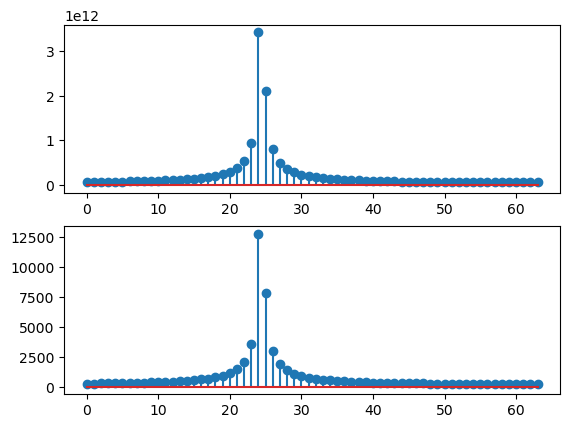

In [73]:
S = radix4_fft64(s_fixed, N)
#S = radix_4_pre(s)
plt.subplot(211)
plt.stem(np.abs(S))
plt.subplot(212)
plt.stem(np.abs(np.fft.fft(s_fixed)))
np.set_printoptions(threshold=np.inf)
print_twiddles(60,False,5)

In [7]:
W64 = np.exp(-1j * 2 * np.pi * 1* np.arange(16) / 64)
print(W64)
print("fixed")
W64 = floating_to_fixed_arr(W64,0)
print(W64)

[1.        +0.j         0.99518473-0.09801714j 0.98078528-0.19509032j
 0.95694034-0.29028468j 0.92387953-0.38268343j 0.88192126-0.47139674j
 0.83146961-0.55557023j 0.77301045-0.63439328j 0.70710678-0.70710678j
 0.63439328-0.77301045j 0.55557023-0.83146961j 0.47139674-0.88192126j
 0.38268343-0.92387953j 0.29028468-0.95694034j 0.19509032-0.98078528j
 0.09801714-0.99518473j]
fixed
[16384.    +0.j 16305. -1606.j 16069. -3196.j 15679. -4756.j
 15137. -6270.j 14449. -7723.j 13623. -9102.j 12665.-10394.j
 11585.-11585.j 10394.-12665.j  9102.-13623.j  7723.-14449.j
  6270.-15137.j  4756.-15679.j  3196.-16069.j  1606.-16305.j]


In [121]:
df = pd.read_csv('/home/sakthi/oai_dev/cmake_targets/ran_build/build/dft_results.csv')
print(df)

      30.000000  40.000000  50.000000  60.000000  70.000000  Unnamed: 5
0      591.2421   637.8748   644.1082   647.2845   743.7192         NaN
1      642.5041   642.6459   645.2150   642.8573  1005.2832         NaN
2      615.9700   621.2069   619.6182   620.5043   725.4452         NaN
3      572.7180   581.7535   576.1601   581.7697   822.5352         NaN
4      267.2440   270.9891   273.4465   268.8925   682.9808         NaN
...         ...        ...        ...        ...        ...         ...
2043    20.2942    20.2948    19.4661    20.9786    20.5264         NaN
2044    25.2402    25.1273    26.5320    25.0958   313.5011         NaN
2045    27.5952    26.7105    26.3680    25.7663   379.2402         NaN
2046    28.4998    28.8806    28.6264    29.4276   228.6837         NaN
2047    30.2206    29.6551    31.0685    30.4439   225.2399         NaN

[2048 rows x 6 columns]


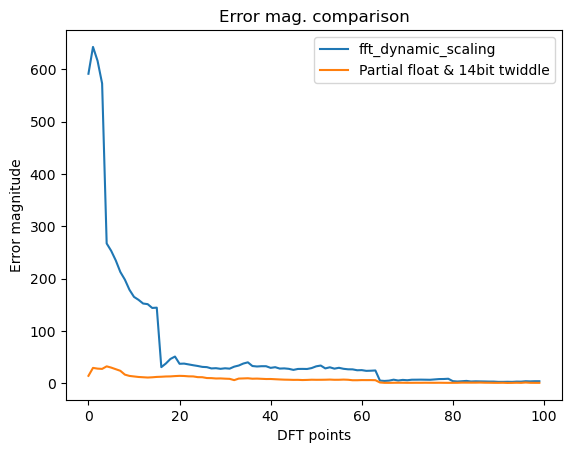

In [126]:
p = df["30.000000"][0:100].plot(legend=True,title='Error mag. comparison')
p.set_xlabel("DFT points")
p.set_ylabel("Error magnitude")
p2 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/dft_results.csv')
p2["30.000000"][0:100].plot(ax=p,legend=True)
#p3 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/dft_results_2048_256float.csv')
#p3["30.000000"][0:100].plot(ax=p,legend=True)
#p4 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/dft_results.csv')
#p4["30.000000"].plot(ax=p,legend=True)
#p.legend(['Develop','256DFT float & 15bit twiddle','256DFT float & 14bit twiddle'])
p.legend(['fft_dynamic_scaling','Partial float & 14bit twiddle'])

In [125]:
fig = p.get_figure()
fig.savefig('2048_first_100_4.pdf')
fig.savefig('2048_first_100_4.png')
fig.savefig('2048_first_100_4.svg')

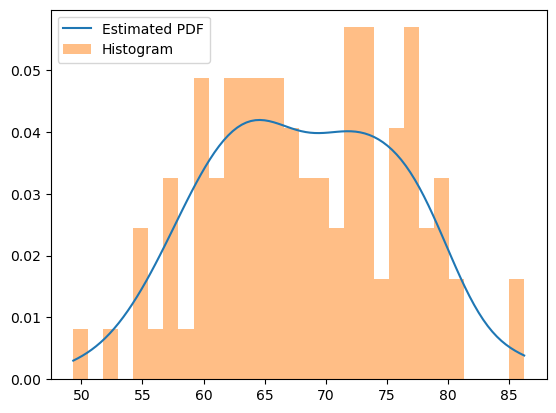

In [13]:
p30 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/error_dist.csv')
data_pdf = p30["4"]
kde = gaussian_kde(data_pdf)
kde_x = np.linspace(min(data_pdf), max(data_pdf), 100)
pdfs = kde(kde_x)
plt.plot(kde_x, pdfs, label="Estimated PDF")
plt.hist(data_pdf, bins=30, density=True, alpha=0.5, label="Histogram")
plt.legend()
plt.show()